In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


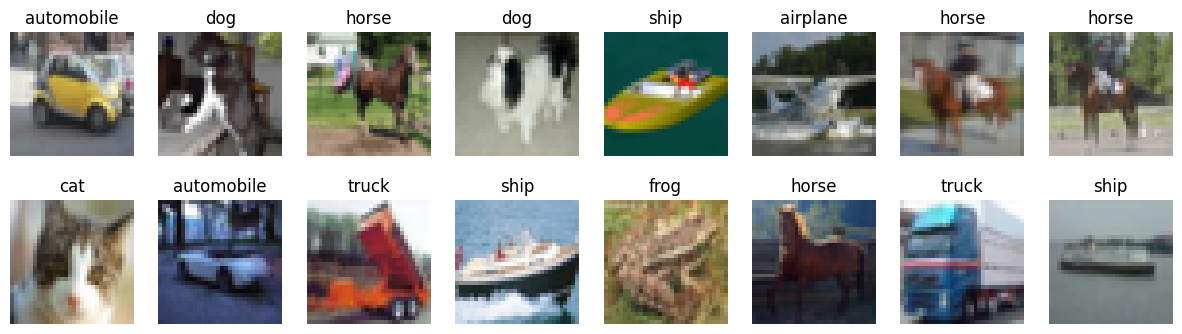

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [25]:
from keras.layers import BatchNormalization, Input
from keras import regularizers

def make_model():
   
    model = Sequential()

    #input Layer (the input is an image that is 32x32 pixels with 3 color channels (RGB).)
    model.add(Input(shape=(32, 32, 3)))

    #First Convolutional Block
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))#convolutional layer aplying 32 kernels of size 3x3
    model.add(MaxPooling2D(pool_size=(2, 2))) #Reduces the spatial dimensions by downsampling.
    
    # Second Convolutional Block
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten()) # Converts the 3D feature maps into a 1D vector. 
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))) #256 neurons in a dense (fully connected) layer + L2 regularization: Helps prevent overfitting.
    model.add(Dropout(0.6))  # Dropout for regularization Randomly turns off 60% of the neurons in this layer during training. Helps prevent overfitting.
    
    # Output Layer
    model.add(Dense(10, activation='softmax')) #Final layer with 10 neurons, one for each class. softmax converts the output into probabilities that sum to 1.

    return model


# Interpretation and development of my code:

I started by building a simple convolutional neural network (CNN) as a baseline. 
It had the following layers :
- One convolutional layer (Conv2D). 
    - I used 30 kernels of size 3X3 taking as imput the 32x32  (RGB) images. This will identify the caracteristics of the image like edges or corner.

- One pooling layer. 
    - Of size 2X2, this reduce the size of the images which help efficiency and reduce chances of overfitting by removing unnecessary details.

- Flatten layer: 
    - It transforms the 3D feature maps into a 1D vector. This step is required because Dense layers need flat vectors, not multi-dimensional arrays.

- Dense layer:
    - To link all the features learned by the convolutional and pooling layers, helping the model make final decisions.

- A Dropout layer 
    - To force the model to explore different paths during training to prevent the model from getting stuck in local minima, avoiding overfitting and helping the model generalize better.

- Output layer:
    - To ensure the output size is the same as the number of classes (10) and to produce probabilities for each class (activation='softmax').

This resulted in a working model but with low accuracy.  
So to resolve this issue i attempted different things: 

- I increased the number of convolutional block (conv + pool): to 3 with increasing kernel amount (32 -> 64 -> 128) which did improve accuracy. So i tried with 6 convolutional layers. The Training accuracy improved, but validation accuracy started to plateau and then decrease. Overfitting became a concern. So i went back to 3 convolutional layers.

- After more than 20 epoch the model started slowly to overfit which indicated the need to implement early stopping at epoch 20 to prevent further overfitting. 

- I added batch normalisation layers which improved accuracy and helped overfitting (I learned that batch normalization helps prevent any neuron from dominating by normalizing the inputs to each layer. This makes the training faster, more stable, and reduces the impact of initial weights.)
I also added padding='same'  which helps the model focus on learning features without losing valuable information from the image edges and ensures more stable and efficient training.

- from there I implemented L2 regularization on dense layers (which penalizes large weights and encourages better generalization.) I also increased dropout rate from 0.4 to 0.6. This helped reduce the gap between training and validation accuracy, but test accuracy stayed around 70–75%. Higher Dropout above 0.6 caused underfitting, reducing both training and test accuracy.

- I tested sigmoid activations in place of ReLU to see if it would helped the model.
The convergence was much slower and no accuracy improvement was noticed. So i kept ReLu.

- I rearranged layers, moving Batch Normalization before conv2D instead of after.
And suprisigly it resulted in a slight improvement in stability during training and accuracy went up to 77%


# conlusion 

After experimenting with different approaches, the model's accuracy improved to 77%. Key changes like adding batch normalization, adjusting dropout rates, and increasing convolutional layers helped the model generalize better and avoid overfitting. However, the improvement plateaued after a certain point, indicating that the model might need further modifications to achieve higher performance. 

it still has some limitations:
- The model still shows a performance gap between training and validation accuracy which could be improved 
- Test accuracy remains around 70-77%, which suggests that the current architecture may not be the most addapted to the problem.
- continuing to explore different architectures, and techniques like data augmentation might also lead to better results.

In [34]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-4  # initial learning rate
BATCH_SIZE = 40
EPOCHS = 20


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.3254 - loss: 2.3284 - val_accuracy: 0.5546 - val_loss: 1.6816
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5118 - loss: 1.7492 - val_accuracy: 0.6157 - val_loss: 1.4158
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5751 - loss: 1.5152 - val_accuracy: 0.6489 - val_loss: 1.2614
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.6185 - loss: 1.3566 - val_accuracy: 0.6785 - val_loss: 1.1686
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.6545 - loss: 1.2247 - val_accuracy: 0.6985 - val_loss: 1.0880
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6768 - loss: 1.1436 - val_accuracy: 0.7086 - val_loss: 1.0427
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6983 - loss: 1.0692 - val_accuracy: 0.7242 - val_loss: 0.9877
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7165 -

In [35]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


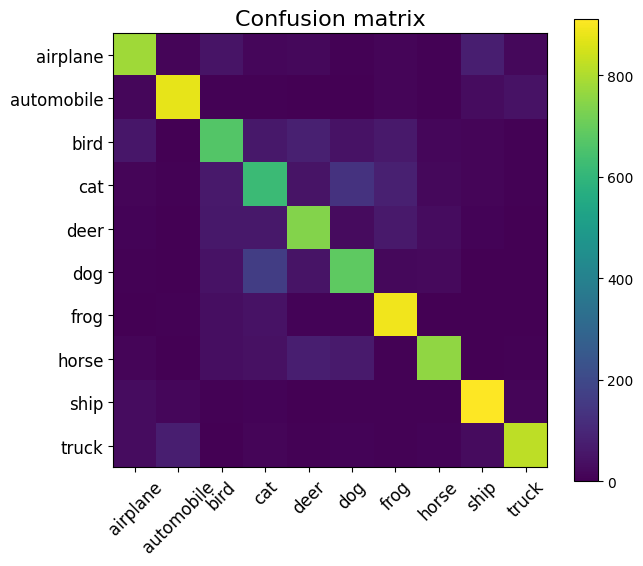

Test accuracy: 0.7745


In [36]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

# Analysis of the confusion matrix

Diagonal (Light Colors): 
   - These cells represent true positives (correct predictions). 
   - Light colors on the diagonal mean that the model is correctly predicting a significant number of events in the classes (since they correspond to values like 700 or more).

Off-Diagonal (Dark Colors):
   - These cells represent misclassifications.
   - Dark colors in these cells (close to 0) mean the model is misclassifying very few events for those categories.

 The fact that the diagonal cells have light colors and high values compared to off-diagonal cells means that the model is correctly classifying a large number of events.

 We can still observe some classes imbalance :
   The model seems very good at identifying automobile, frog and ship but struggles more with cats and birds. It appears to particularly confuse cats and dogs. (slightly lighter cell from the off-diagonal cells).


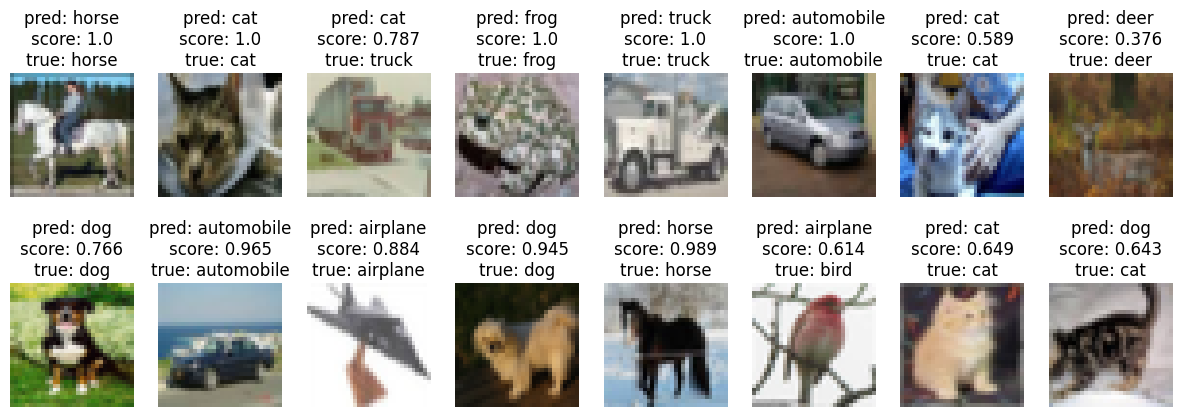

In [33]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


